# Dynamic heat conduction example for NPyfem

In [1]:
import numpy as np
import scipy.sparse as sps
import meshio as mio

from npyfem.mesh import NPMesh

import npyfem.dirichletbc as dbc
from npyfem.basis import scalarbasis as sbasis
import npyfem.npstruct as nps
from npyfem.iotools import vtk_io as vtk

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt


Solve a heat diffusion problem with time dependent Dirichlet condition 
and time dependent heating in 2D domain. 

$$
\begin{align}
c \frac{du}{dt} - \nabla \cdot ( k \nabla u) = f(t)
\end{align}
$$
with boundary conditions and source terms
$$
\begin{align}
u(x,t) &= cost(t) \;& \mbox{when } x \in \mbox{NORTH} \\
u(x,t) &= 0 \; & \mbox{when } x \in \mbox{SOUTH} \\
f(t) &= t^2 \; ,\\
\end{align}
$$
over time period $t \in [0, 6\pi]$.

We use a mesh created with gmsh (beast_2d) which contains areas of triangles, quadrangles and an area with mixed elements containing both.

In [2]:

rawmsh = mio.read('../../resources/beast_2d.msh')
msh = NPMesh(rawmsh)

# Domain identifiers, these are defined in GMSH when mesh is created (physical entities)
DOMAIN = 1
NORTH = 2
EAST = 5
SOUTH = 3
WEST = 4

ndofs = msh.ndofs

# constants
c = 10
k = 10

domain = msh.define_domain([DOMAIN])

It may be convenient to organize the code to single shot functions in 
order to reduce the amount of single-use variables polluting the namespace.
It is naturally sometimes more efficient to re-use some variables.

First compute the stiffness matrix through first computing local stiffness matrices
$$
\begin{align}
K_l = \int_{\Omega} < \nabla N_{el}, \nabla N_{el} > d \Omega
\end{align}
$$
The expression 
```
(k * dNxy.transpose([1,0]) @ dNxy * Jdet1).integrate().assemble()
```
relies on NPStruct object (defined in npstruct.py) which contains a dictionary of numpy arrays and overloads certain operators abstracting the mesh and basis details (element type, integration points etc.) away from the user. 

The term inside the brackets evaluates to an NPStruct containing the integrand evaluated in integration points. Calling on method ```integrate()``` evaluates to an NPStruct object containing the local stiffness matrices of elements. Calling on ```assemble()``` uses the mesh connectivity information to assemble the global stiffness matrix as ```scipy.csr_matrix```. 

In [3]:
def compute_stiffmat():
    # derivatives of basis functions
    dN = nps.d_basis(domain, 1)
    
    # isoparametric jacobian determinants, last parameter is the columns
    # of jacobians because we have embedded 2D elements in 3D (workaround)
    Jdet1 = nps.det_jacobians(domain, 1, [0,1])
    
    # push reference basis functions to xy coordinates
    jac = nps.jacobians(domain, 1, [0,1])
    dNxy = jac.backslash(dN)

    # compute the local stiffness matrices: K = int( dN^T * dN * detJ )
    # and assemble the system
    return (k * dNxy.transpose([1,0]) @ dNxy * Jdet1).integrate().assemble()

K = compute_stiffmat()

Similarly we can compute the damping matrix and some more special expressions, such as the area of the mesh and a matrix which divides the source evenly to the domain.

In [4]:
def compute_damping_mat():
    """ Compute damping matrix, needs 2 order integration points """
    N = nps.basis(domain, 2)
    Jdet2 = nps.det_jacobians(domain, 2, [0,1])
    return (c * N.transpose([1,0]) @ N * Jdet2).integrate().assemble()

T = compute_damping_mat()

def compute_domain_area(): 
    """ Compute the area of the domain from metric tensor g """
    jac = nps.jacobians(domain, 1)
    detg = (jac@jac.transpose([1,0])).det()
    sqrt_detg = detg.unary_map(lambda x: np.sqrt(x)[...,None,None])

    return np.sum(sqrt_detg.integrate().assemble().toarray())

Adom = compute_domain_area()

def compute_heat_divider(): 
    """ Compute a vector which distributes heating to the domain evenly """
    N = nps.basis(domain, 1)
    detJ1 = nps.det_jacobians(domain, 1, [0,1])
    return (1/Adom * N.transpose([1,0]) * detJ1).integrate().assemble()

Cc = compute_heat_divider()

In [5]:
# Time stepping information
timesteps = 400
ts = np.linspace(0, 8*np.pi, timesteps)
delta_t = ts[1]-ts[0]

Module ```dirichletbc.py``` offers some functions to manipulate global system matrices if one wants to set boundary conditions. 

Here we use the most flexible way where we construct matrices ```Otot``` and ```Itot``` which can be used to set the conditions on our system matrices. These matrices can be composed using multiplication and summation respectively if one has multiple boundary conditions which need to be set.

In [6]:
# Dof numbers of the boundaries where BC's are set.
north_dofs = msh.get_global_nodeids([NORTH])
south_dofs = msh.get_global_nodeids([SOUTH])

# Initialize boundary condition array, shape (timesteps, dofs)
Bcs = np.cos(ts)[:,None] @ np.ones((1, north_dofs.shape[0]))
dBcsdt = -np.sin(ts)[:,None] @ np.ones((1, north_dofs.shape[0]))

Bc_south = np.zeros((south_dofs.shape[0], 1))

# Initialize source vector arrays
Fs = ts[:,None]**2 @ Cc.T

# Compute a mapping which sets rows and columns to zero, 
Otot = dbc.zero_rowcols_mapping(north_dofs, ndofs) * \
       dbc.zero_rowcols_mapping(south_dofs, ndofs)

# Compute mapping which helps to set diagonal elements to one to use on 
# dirichlet BC setting  
Itot = dbc.ones_to_diag_matrix(north_dofs, ndofs) + \
       dbc.ones_to_diag_matrix(south_dofs, ndofs)

First we need to compute an initial state which we use as initial condition.

In [7]:
# compute the equilibrium state for initial condition
def equilibrium():
    # compute dirichlet coupling terms to be substracted from right hand side
    Q = dbc.coupling(K, north_dofs, Bcs[0])
    
    # Zero rows and columns and set diagonals to 1
    Kbc = Otot*K*Otot + Itot
    
    # set BC's to right hand side
    # We need to add extra axis with [:,None] to avoid 
    # wrong kind of broadcasting behaviour
    Fbc = Fs[0][:,None] - Q
    Fbc[north_dofs] = Bcs[0][:,None]
    Fbc[south_dofs] = 0
    
    return sps.linalg.spsolve(Kbc, Fbc)

u0 = equilibrium()
up = u0
      

This cell runs the time stepping. We use Backward Euler scheme in this example.

In [8]:
Tdt = 1/delta_t*T

#%%
us = []

for ti in range(0,timesteps):
    
    # Compute the Dirichlet coupling terms to the right hand side 
    # from original K and T
    Q = dbc.coupling(K, north_dofs, Bcs[ti]) + \
        dbc.coupling(T, north_dofs, dBcsdt[ti])
        
    Lhs = Tdt + K    
    Rhs = Fs[ti][:,None] - Q + Tdt@up[:,None]
    
    # Set dirichlet node rows and columns
    Lhs = Otot*Lhs*Otot + Itot
    
    # Set boundary values
    Rhs[north_dofs] = Bcs[ti][:,None]
    Rhs[south_dofs] = 0
        
    u = sps.linalg.spsolve(Lhs, Rhs)
    
    us.append(u)
    up = u
    

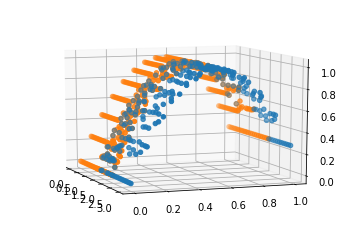

In [9]:
# Plotting function for checking out the solution

def plot(u):
    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='3d')
    for phys, eg in msh.iterate_physical_domains([DOMAIN]):
        xs, ys, _ = eg.lnode_coords.T
        F = u[eg.global_nodeids]
        ax.view_init(elev=10., azim=-20.)
        ax.scatter(xs,ys,F)
        
# Plot 220:th time step solution for example.
plot(us[220])

If you have paraview installed, you can export the data and open it in paraview. For this you need to create ```heat_cond_state.pvsm``` state file in order to store the visualization pipeline between simulation runs.

In [10]:
#%% * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
#   Export to paraview for Maximum Viewing Pleasure (TM)

solution = np.stack(us)

fnamef = "heat_cond"

## Ensure that the folder to store results exists
import os, errno

try:
    os.makedirs(fnamef)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

vtk.export_time_fields(msh, fnamef, ts, 
                   pointdata={'u': solution})

#%% * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#   Show in paraview
from subprocess import Popen

Popen(["paraview", "--state=heat_cond_state.pvsm"])


    